# Network Traffic Anomaly Detection

This notebook demonstrates how to detect anomalies in network traffic data using machine learning techniques. The project follows a structured workflow: data acquisition, preprocessing, feature engineering, unsupervised and supervised modeling, and evaluation.

In [2]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import requests
import os

## Phase 1: Data Acquisition

We will use the NSL-KDD dataset, a widely used benchmark for network intrusion detection. The dataset will be downloaded and loaded for analysis.

In [3]:
# Download the NSL-KDD dataset (KDDTrain+ and KDDTest+)
# Source: https://www.unb.ca/cic/datasets/nsl.html
train_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain+.txt"
test_url = "https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest+.txt"
data_dir = "data"
os.makedirs(data_dir, exist_ok=True)
train_path = os.path.join(data_dir, "KDDTrain+.txt")
test_path = os.path.join(data_dir, "KDDTest+.txt")

for url, path in zip([train_url, test_url], [train_path, test_path]):
    if not os.path.exists(path):
        r = requests.get(url)
        with open(path, "wb") as f:
            f.write(r.content)
        print(f"Downloaded {path}")
    else:
        print(f"{path} already exists.")

Downloaded data/KDDTrain+.txt
Downloaded data/KDDTest+.txt


In [4]:
# Load the NSL-KDD dataset into pandas DataFrames
col_names = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes',
    'land', 'wrong_fragment', 'urgent', 'hot', 'num_failed_logins',
    'logged_in', 'num_compromised', 'root_shell', 'su_attempted',
    'num_root', 'num_file_creations', 'num_shells', 'num_access_files',
    'num_outbound_cmds', 'is_host_login', 'is_guest_login', 'count',
    'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
    'dst_host_srv_rerror_rate', 'label', 'difficulty'
]
train_df = pd.read_csv(train_path, names=col_names)
test_df = pd.read_csv(test_path, names=col_names)
print(f"Train shape: {train_df.shape}, Test shape: {test_df.shape}")
train_df.head()

Train shape: (125973, 43), Test shape: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


## Phase 2: Data Preprocessing & Exploration

Now that the data is loaded, we will:
- Inspect the dataset for missing values and data types
- Clean and preprocess the data (handle missing values, encode categorical features, normalization)
- Perform exploratory data analysis (EDA) to understand feature distributions and correlations
- Visualize key statistics and patterns

Train Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125973 non-null  int64  
 1   protocol_type                125973 non-null  object 
 2   service                      125973 non-null  object 
 3   flag                         125973 non-null  object 
 4   src_bytes                    125973 non-null  int64  
 5   dst_bytes                    125973 non-null  int64  
 6   land                         125973 non-null  int64  
 7   wrong_fragment               125973 non-null  int64  
 8   urgent                       125973 non-null  int64  
 9   hot                          125973 non-null  int64  
 10  num_failed_logins            125973 non-null  int64  
 11  logged_in                    125973 non-null  int64  
 12  num_compromised              125973 non-n

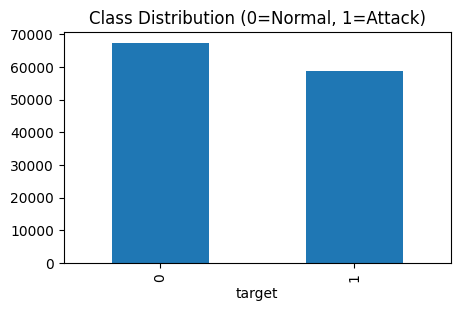

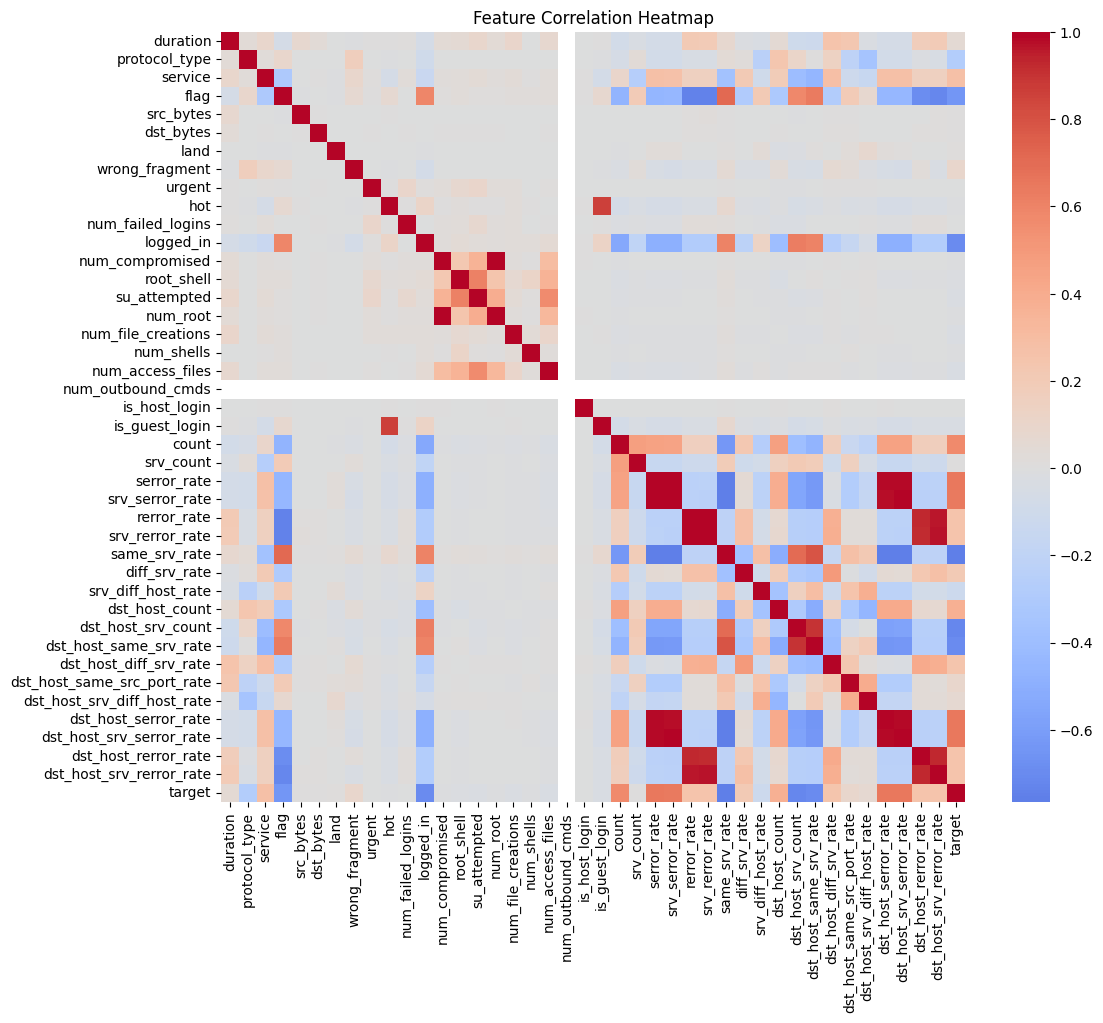

In [5]:
# Inspect for missing values and data types
print("Train Data Info:")
train_df.info()
print("\nTest Data Info:")
test_df.info()
print("\nMissing values in train:")
print(train_df.isnull().sum().sum())
print("Missing values in test:")
print(test_df.isnull().sum().sum())
"""
Encode categorical features: protocol_type, service, flag
Label encode the target variable (label)
"""
cat_cols = ['protocol_type', 'service', 'flag']
for col in cat_cols:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
# Encode target variable: normal=0, attack=1
train_df['target'] = (train_df['label'] != 'normal').astype(int)
test_df['target'] = (test_df['label'] != 'normal').astype(int)
print(train_df[['label', 'target']].head())
"""
Drop columns not needed for modeling (e.g., 'difficulty', 'label')
"""
drop_cols = ['difficulty', 'label']
train_df = train_df.drop(columns=drop_cols)
test_df = test_df.drop(columns=drop_cols)
print(f"Train columns: {train_df.columns.tolist()}")
"""
Normalize numerical features
"""
num_cols = train_df.select_dtypes(include=[np.number]).columns.drop('target')
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])
print(train_df[num_cols].describe().T.head())
"""
Exploratory Data Analysis (EDA):
- Class distribution
- Correlation heatmap
- Feature distributions
"""
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(5,3))
train_df['target'].value_counts().plot(kind='bar', title='Class Distribution (0=Normal, 1=Attack)')
plt.show()
plt.figure(figsize=(12,10))
sns.heatmap(train_df.corr(), cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.show()